In [1]:
from __future__ import annotations

import ast
import typing as T
import collections.abc as C

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.axes import Axes

In [5]:
def load_dataset(filepath: str) -> pd.DataFrame:
    def parse_values(x: pd.Series) -> pd.Series:
        keys = ast.literal_eval(x.loc["keys"])[0]
        values = (
            float(x) if x != "null" else pd.NA
            for x in ast.literal_eval(x.loc["values"])[0]
        )
        return pd.Series(dict(zip(keys, values)))

    df = pd.read_csv(filepath, parse_dates=[2], index_col=2).sort_index()
    values = df.apply(parse_values, axis=1)
    df = pd.concat([df[["id", "configuration_item_id"]], values], axis=1)
    return df.convert_dtypes()

In [6]:
X_train = load_dataset("data/train999.csv")

In [51]:
def plot_dataset(df: pd.DataFrame, suptitle: str | None = None):
    meteo_cols = [col for col in df.columns if col.startswith("meteo")]
    df[meteo_cols].plot(
        figsize=(10, 12),
        subplots=True,
        layout=(len(meteo_cols), 1),
    )
    if suptitle:
        plt.suptitle(suptitle)

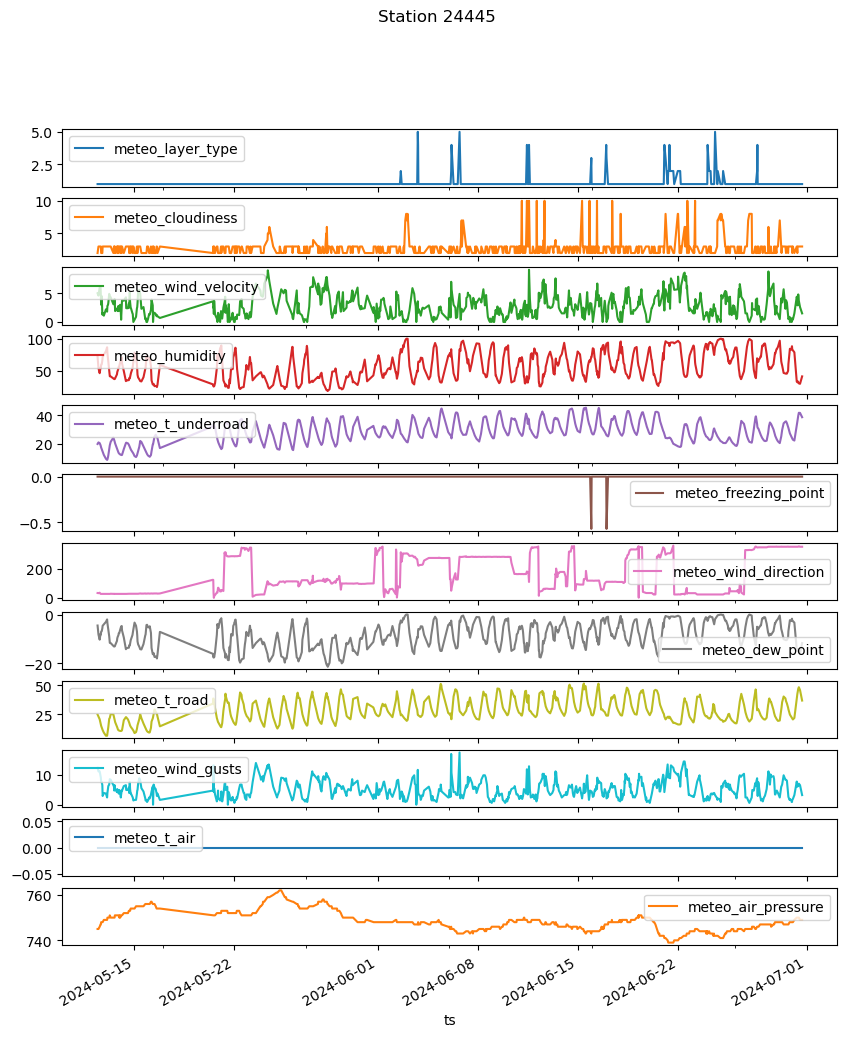

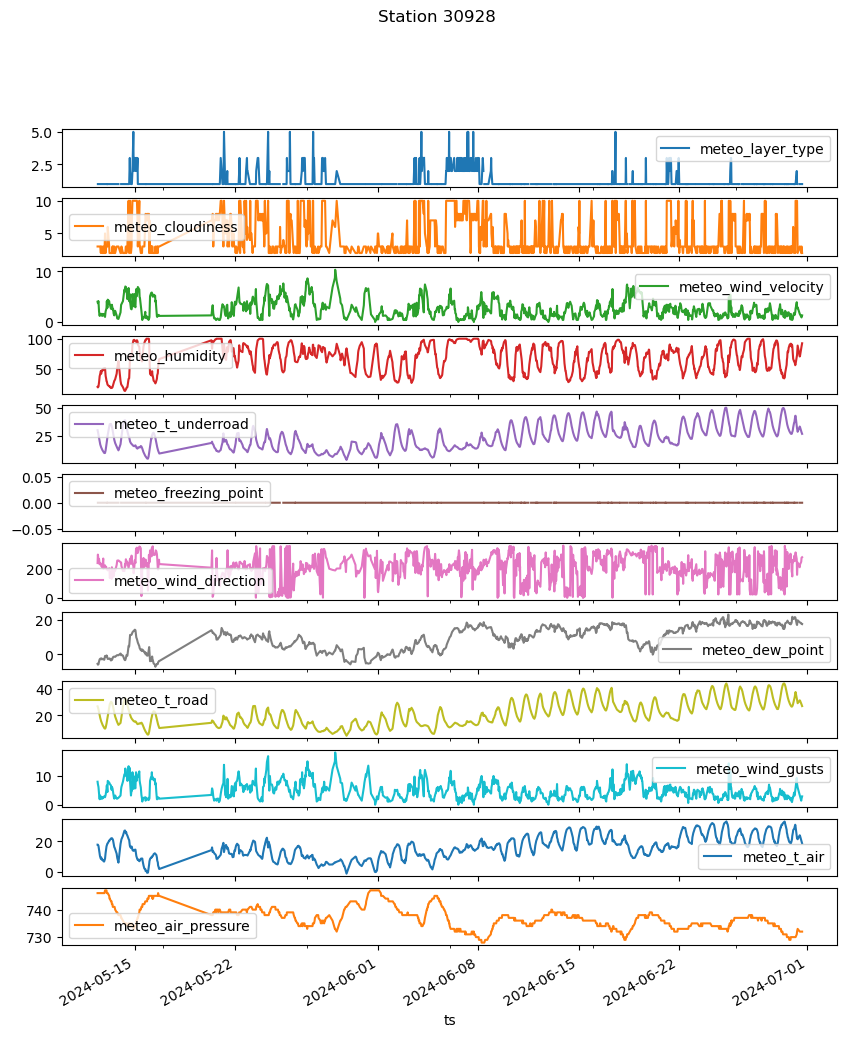

In [52]:
grouped = X_train.groupby("configuration_item_id")
for station, df in grouped:
    plot_dataset(df, suptitle=f"Station {station}")

In [68]:
class MeteoParams(T.TypedDict):
    ths: T.Sequence[float]
    ewm: dict

def test_params(series: pd.Series, params: MeteoParams):
    ths = params["ths"]
    ewm_params = params["ewm"]

    fig, axes = plt.subplots(len(ths), 1, sharex="col", figsize=(10, 3 * len(ths)))
    axes = axes.flat
    axes = T.cast(C.Sequence[Axes], axes)

    for th, ax in zip(ths, axes):
        ewma = series.ewm(**ewm_params).mean().rename("ewma")

        outliers = series.sub(ewma).abs().gt(th)
        s_o = series[outliers].rename("outliers")
        s_i = series[~outliers].rename("inliers")

        ewma.plot(ax=ax)
        s_o.plot(ax=ax, style=".", color="red")
        s_i.plot(ax=ax, style=".", color="green")
        ax.set_title(
            f"{th = :.2f}, found = {len(s_o)} ({len(s_o)/len(series)*100:.2f}%)"
        )

    fig.subplots_adjust(hspace=0.5)

In [62]:
default_params: MeteoParams = {
    "ths": list(range(1, 10)),
    "ewm": {"span": 2},
}

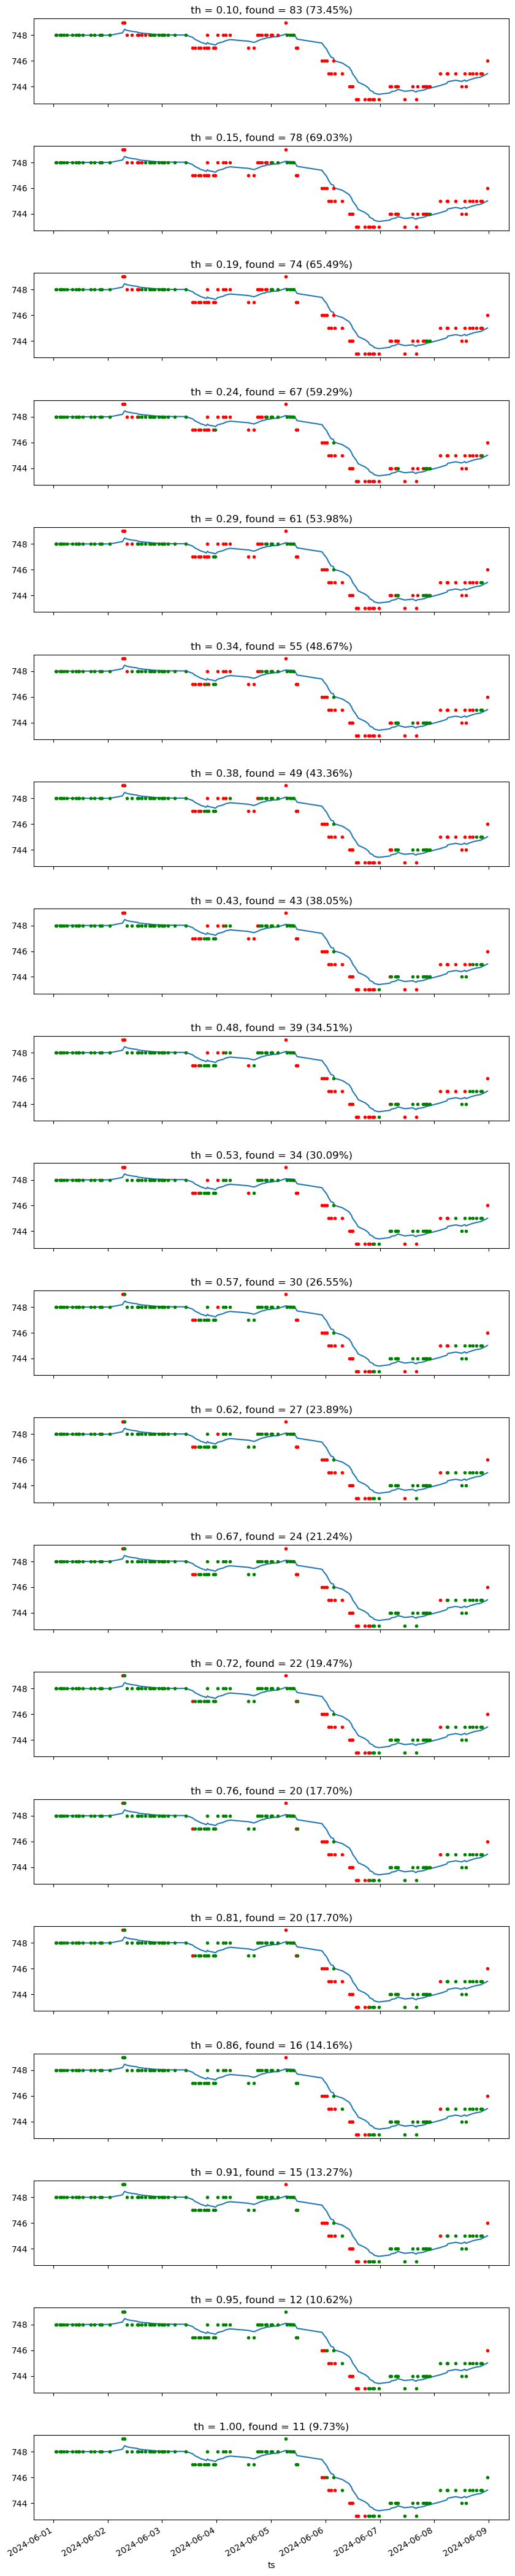

In [76]:
col = "meteo_air_pressure"
params: MeteoParams = {
    **default_params,
    "ths": list(np.linspace(0.1, 1, 20)),
    "ewm": {"span": 10},
}

for station, df in X_train.groupby("configuration_item_id"):
    test_params(df[col].loc["2024-06-01":"2024-06-08"], params)
    break  # run once

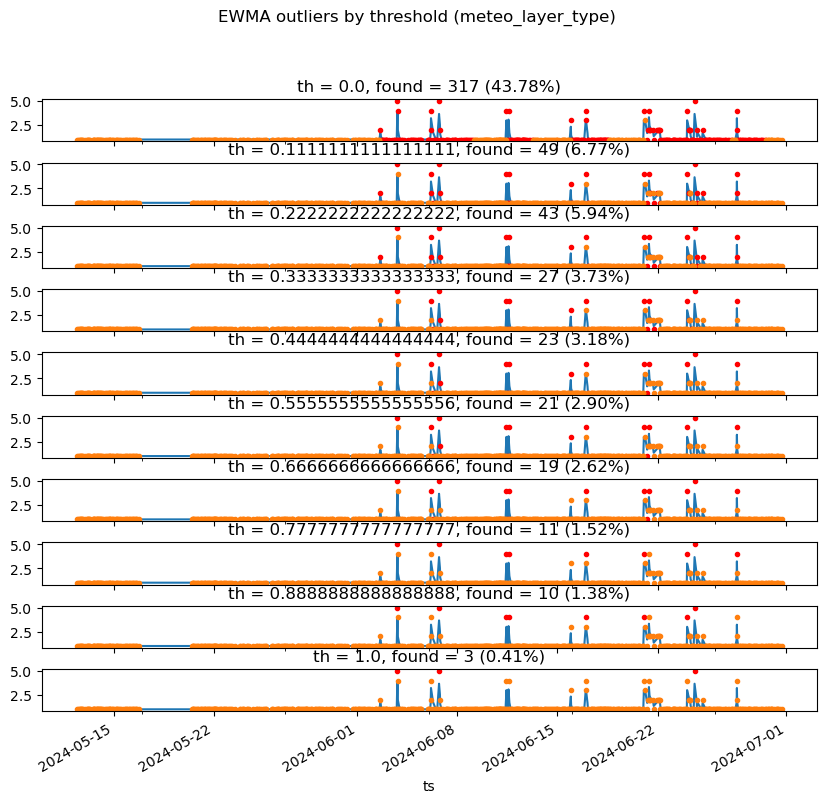

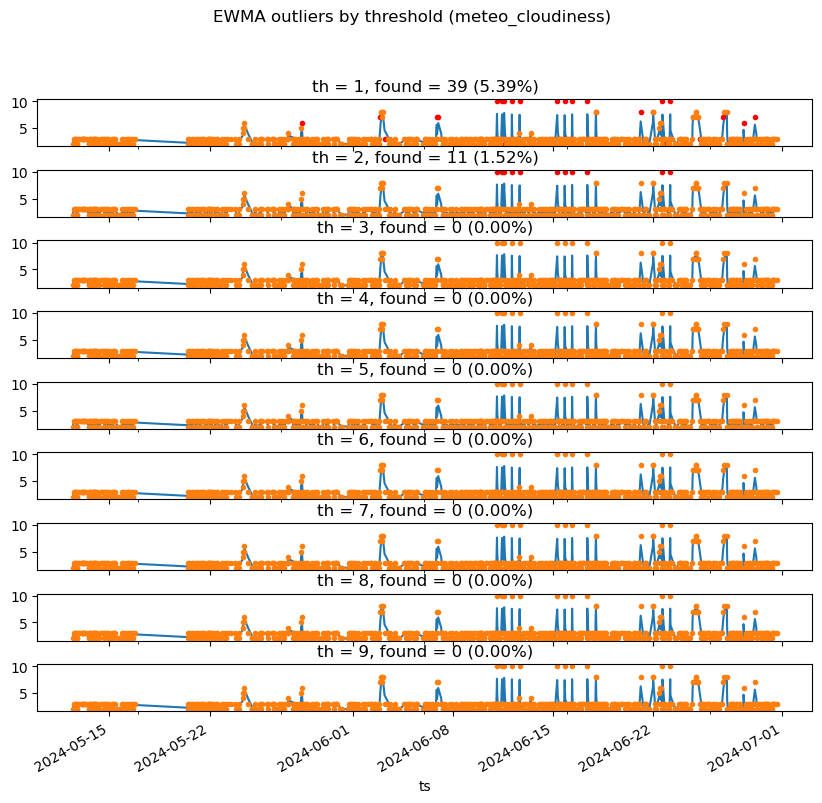

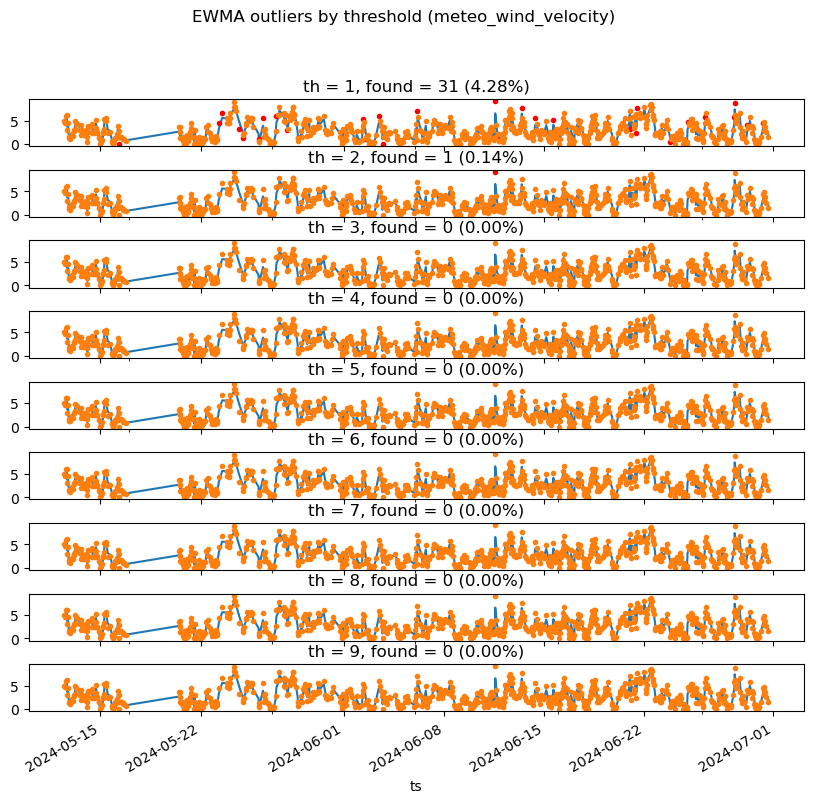

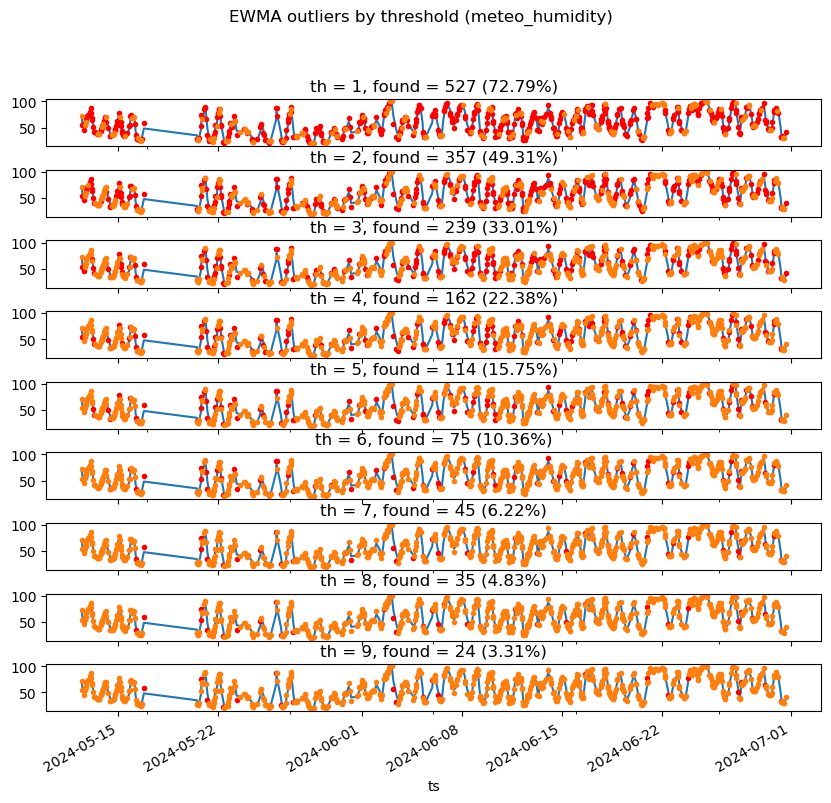

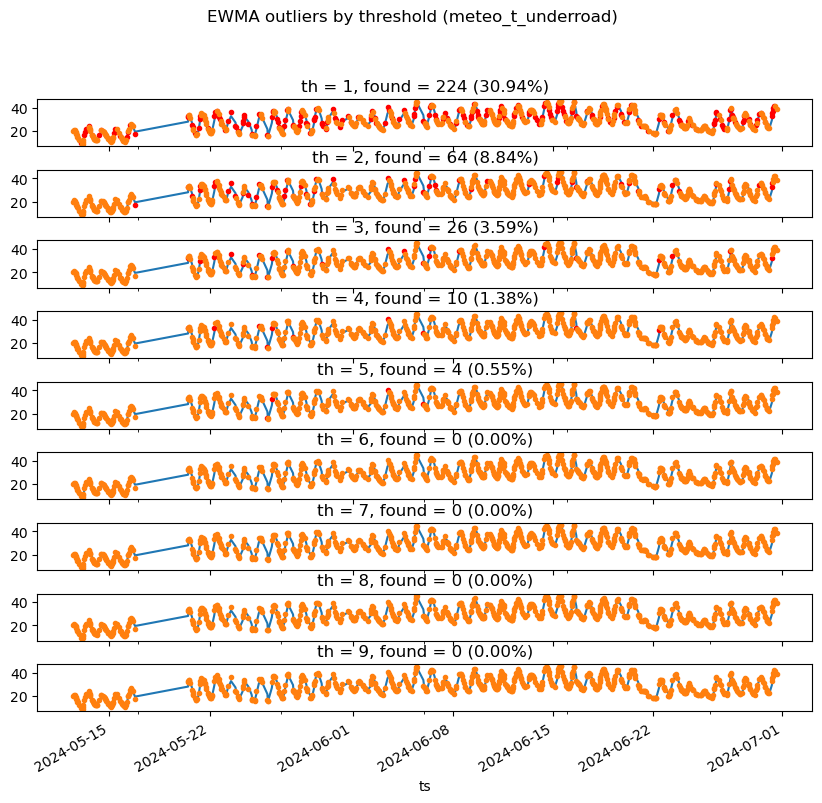

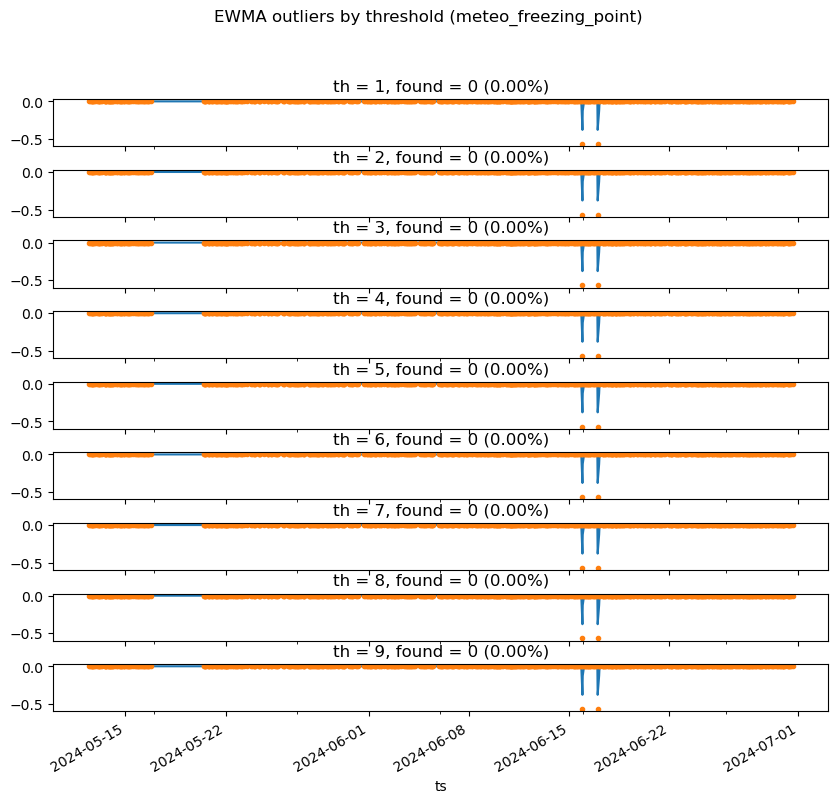

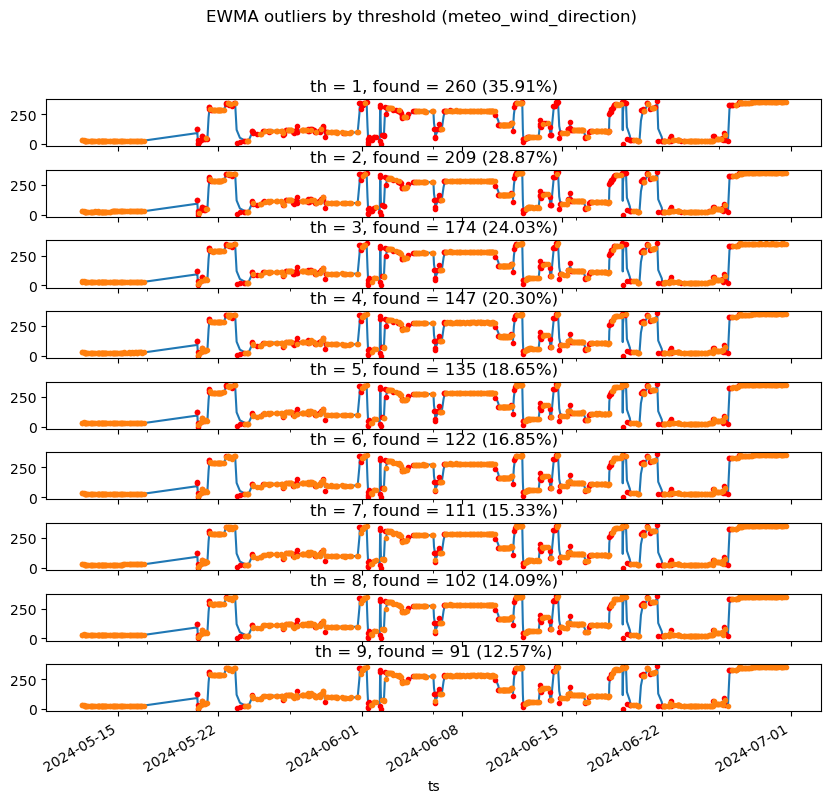

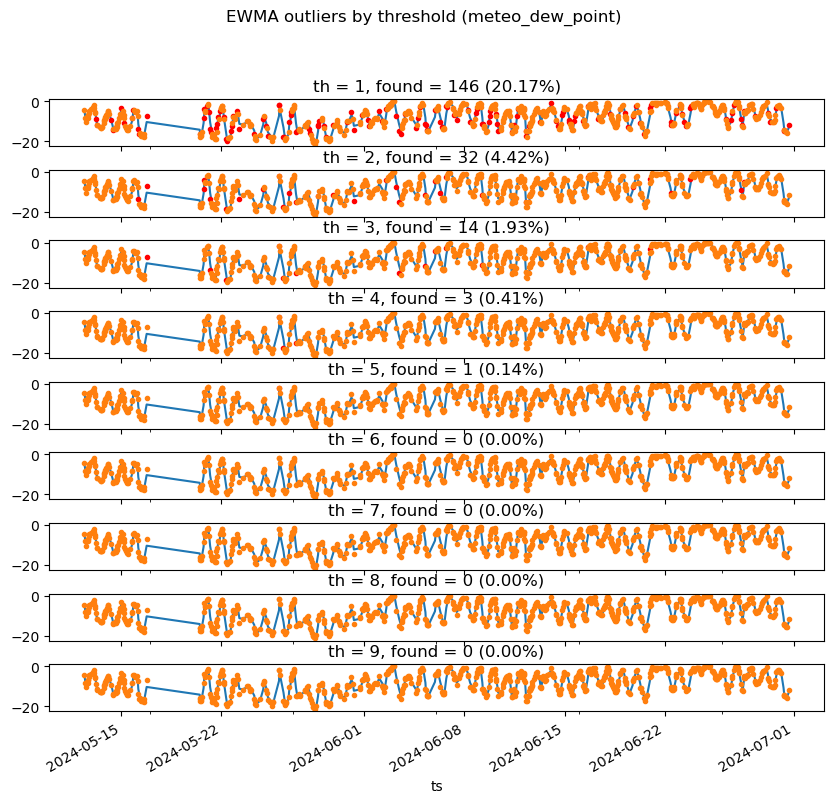

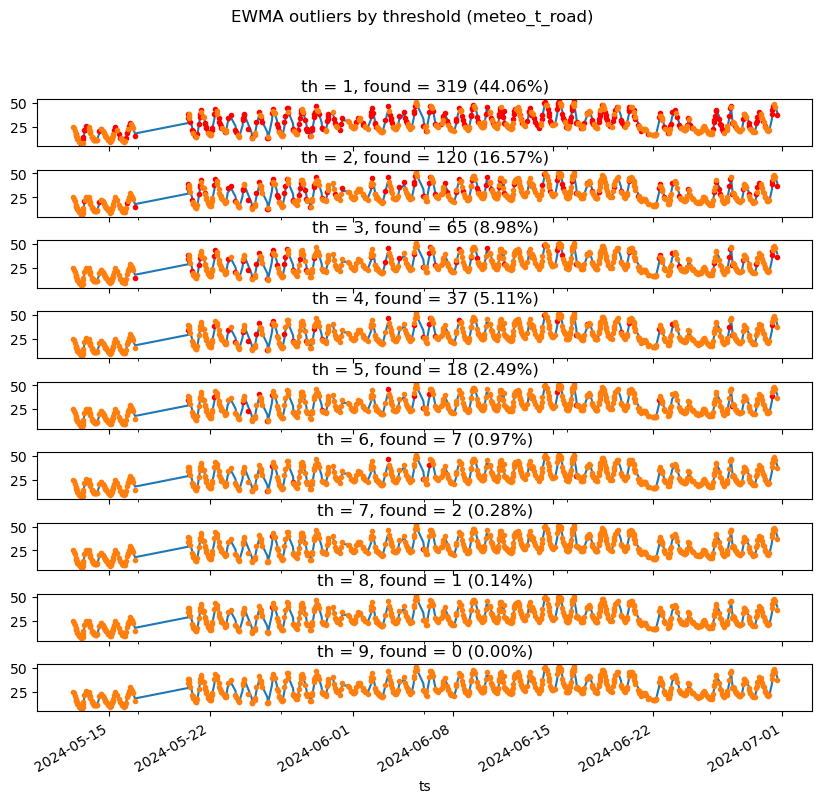

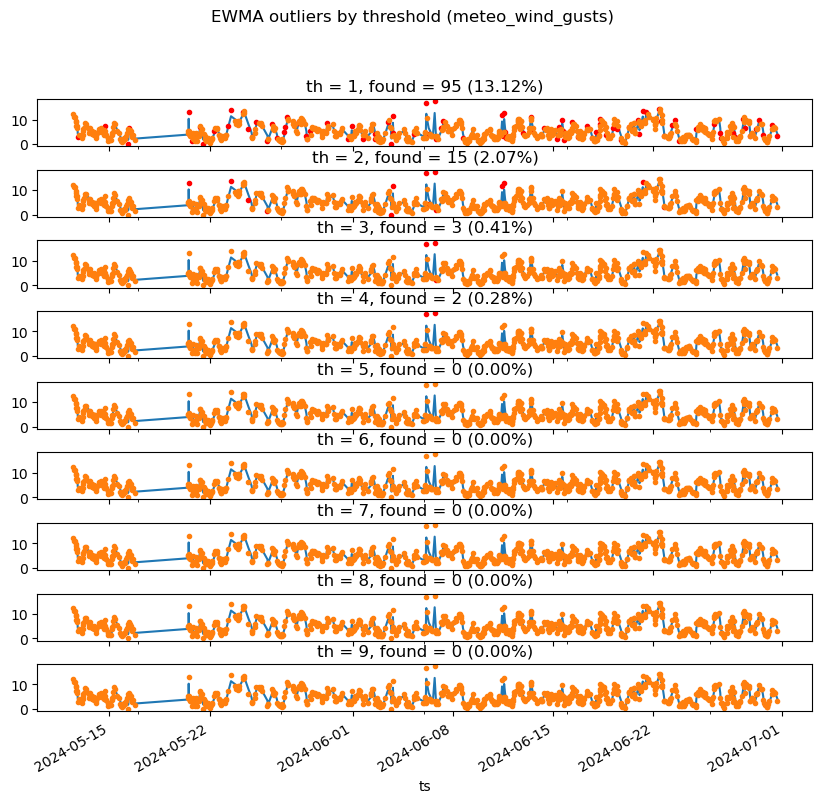

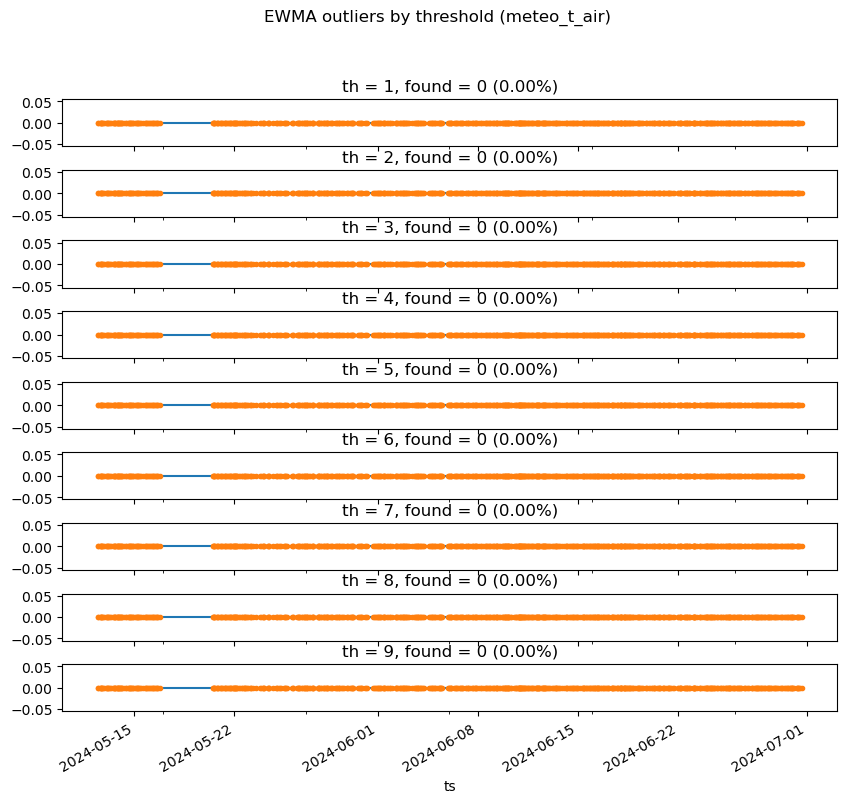

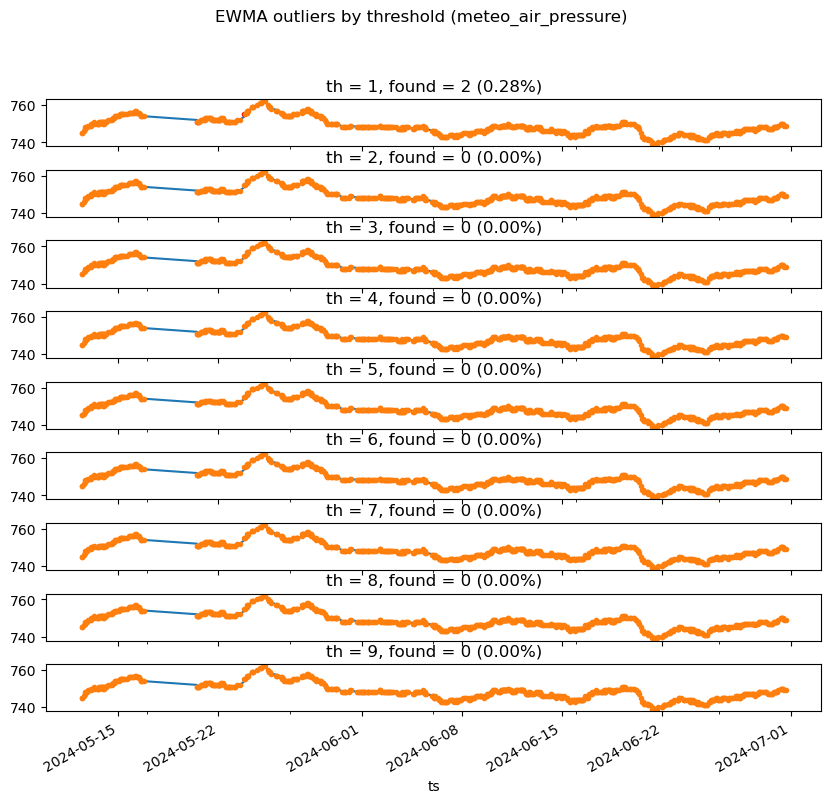

In [56]:
class MeteoParams(T.TypedDict):
    ths: T.Sequence[float]
    ewm: dict

default_params: MeteoParams = {
    "ths": list(range(1, 10)),
    "ewm": {"span": 2},
}

meteo_ewm_params: dict[str, MeteoParams] = {
    "meteo_air_pressure": default_params,
    "meteo_cloudiness": default_params,
    "meteo_dew_point": default_params,
    "meteo_freezing_point": default_params,
    "meteo_humidity": default_params,
    "meteo_layer_type": {
        **default_params,
        "ths": list(np.linspace(0, 1, 10)),
    },
    "meteo_t_air": default_params,
    "meteo_t_road": default_params,
    "meteo_t_underroad": default_params,
    "meteo_wind_direction": default_params,
    "meteo_wind_gusts": default_params,
    "meteo_wind_velocity": default_params,
}

for station, df in X_train.groupby("configuration_item_id"):
    meteo_items = (
        (str(col), series) for col, series in df.items() if str(col).startswith("meteo")
    )
    for col, series in meteo_items:
        params = meteo_ewm_params[col]
        ths = params["ths"]
        ewm_params = params["ewm"]

        fig, axes = plt.subplots(len(ths), 1, sharex="col")
        axes = axes.flat
        axes = T.cast(C.Sequence[Axes], axes)

        for th, ax in zip(ths, axes):
            ewma = series.ewm(**ewm_params).mean().rename("ewma")

            outliers = series.sub(ewma).abs().gt(th)
            s_o = series[outliers].rename("outliers")
            s_i = series[~outliers].rename("inliers")

            ewma.plot(ax=ax)
            s_o.plot(ax=ax, style=".", color="red")
            s_i.plot(ax=ax, style=".")
            ax.set_title(
                f"{th = }, found = {len(s_o)} ({len(s_o)/len(series)*100:.2f}%)"
            )

        fig.suptitle(f"EWMA outliers by threshold ({col})")
        fig.subplots_adjust(hspace=0.5)
        fig.set_size_inches(10, 9)

    break

In [89]:
def run_ewma(df: pd.DataFrame, ewma_params: dict, out_csv_file=None):
    results = df.copy().sort_values("ts")
    cols = []

    df = df.copy()
    df["id"] = df.index
    df = df.set_index("ts").sort_index()

    fig, axes = plt.subplots(len(ewma_params), 1, sharex="col")
    axes_iter = iter(axes.flat)

    for name, series in df.items():
        if name not in ewma_params:
            continue

        ax = next(axes_iter)
        p = ewma_params[str(name)].copy()
        th = p.pop("th")

        ewma = series.ewm(**p).mean().rename("ewma")
        outliers = series.sub(ewma).abs().gt(th).fillna(True)
        s_o = series[outliers].rename("outliers")
        s_i = series[~outliers].rename("inliers")

        col = f"a{len(cols)}"
        cols.append(col)
        results = results.assign(**{col: outliers.astype(int).values})

        plot_interval = slice("2024-06-01", "2024-06-08")

        ewma.loc[plot_interval].plot(ax=ax)
        s_o.loc[plot_interval].plot(ax=ax, style=".")
        s_i.loc[plot_interval].plot(ax=ax, style=".")
        ax.set_title(f"{name}, {th = } ({len(s_o)/len(series)*100:.2f}%)")

    fig.suptitle(f"EWMA outliers")
    fig.subplots_adjust(hspace=0.5)
    fig.set_size_inches(12, 18)

    if out_csv_file:
        results["target"] = results[cols].agg(
            lambda x: "[%s]" % ", ".join(map(str, x)), axis=1
        )
        results["target"].to_csv(out_csv_file)

In [53]:
default_span = 2

ewma_params = {
        "meteo_air_pressure": {"th": 5, "span": default_span},
        "meteo_cloudiness": {"th": 2, "span": default_span},
        "meteo_dew_point": {"th": 9, "span": default_span},
        "meteo_freezing_point": {"th": 0.01, "span": default_span},
        "meteo_humidity": {"th": 20, "span": default_span},
        "meteo_layer_type": {"th": 1, "span": default_span},
        "meteo_t_air": {"th": 9, "span": default_span},
        "meteo_t_road": {"th": 8, "span": default_span},
        "meteo_t_underroad": {"th": 7, "span": default_span},
        "meteo_wind_direction": {"th": 100, "span": default_span},
        "meteo_wind_gusts": {"th": 3, "span": default_span},
        "meteo_wind_velocity": {"th": 1.5, "span": default_span},
    }

for station, df in X_train.groupby("configuration_item_id"):
    run_ewma(df, ewma_params)
    break

NameError: name 'run_ewma' is not defined